In [154]:
# load model

import cobra

# model originally from:
# Caspeta L, Shoaie S, Agren R, et al (2012) Genome-scale metabolic reconstructions of Pichia stipitis and Pichia pastoris and in silico evaluation of their potentials. BMC Syst Biol 6:24. doi: 10.1186/1752-0509-6-24.

# model with heterologous protein production was used as starting point for our simulation:
# Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.

# it is common for these models to give some warnings when uploaded for the first time, so in order to avoid them, it is just required to rewrite the model as follows

#pheast = cobra.io.read_sbml_model("./data/ihGlycopastoris.xml")
#cobra.io.write_sbml_model(pheast,"./data/ihGlycopastoris_rewritten.xml")

pheast = cobra.io.read_sbml_model("./data/ihGlycopastoris_rewritten.xml")

In [151]:
# In the original model the production of FAB protein was included, but we want to remove its reactions
# those will be include protein transport and protein production (dna, rna, amino acid sequence and protein)
pheast.reactions.query("FAB", "name")

[<Reaction r1338 at 0x26bcb3682e8>,
 <Reaction r1337 at 0x26bcb389cc0>,
 <Reaction r1100 at 0x26bcb398d68>,
 <Reaction r1101 at 0x26bcb398ef0>,
 <Reaction r1102 at 0x26bcb3a6fd0>,
 <Reaction r1103 at 0x26bcb398f28>]

In [152]:
# we also remove the metabolites related to FAB, which will be those related to dna, rna and amino acid sequence, as well as the protein in different compartments
pheast.metabolites.query("FAB", "name")

[<Metabolite m1360 at 0x26bc9cca860>,
 <Metabolite m1361 at 0x26bc9cca908>,
 <Metabolite m1362 at 0x26bc9cca9b0>,
 <Metabolite m1363 at 0x26bc9ccaa90>,
 <Metabolite m1364 at 0x26bc9ccab70>]

In [155]:
# first remove the heterologous protein production reactions from the paper

pheast.remove_reactions([pheast.reactions.r1337,
                        pheast.reactions.r1338,
                        pheast.reactions.r1100,
                        pheast.reactions.r1101,
                        pheast.reactions.r1102,
                        pheast.reactions.r1103])

# and all the species related to the protein (dna, rna, aa and the protein on different compartments)

pheast.remove_metabolites([pheast.metabolites.m1360,
                          pheast.metabolites.m1361,
                          pheast.metabolites.m1362,
                          pheast.metabolites.m1363,
                          pheast.metabolites.m1364])

In [8]:
# run the model/optimizes for cell growth
# the usual approach for these models is to optimize cell growth/biomass production, which is also done here (reaction r1339 in this model)
# one can always choose other reactions to be optimized, as will be seen later on

pheast.summary()

# comment: I think for documentation is nice to specify why these two different functions (it is not required to run optimize before summary)
# optimize() and summary() methods run the same process, but as the name indicates, summary outputs some information for uptake and secretion besides the optimization result, offered by optimize() method

Metabolite,Reaction,Flux,C-Number,C-Flux
m2,r1145,1,0,0.00%
m1231,r1159,0.4626,0,0.00%
m1232,r1160,0.7967,0,0.00%
m1224,r1164,0.03312,0,0.00%
m1233,r1169,0.002458,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1226,r1133,-0.08024,0,0.00%
m1244,r1137,-1.597,0,0.00%
m30,r1150,-3.43,0,0.00%


In [6]:
# comment: I would introduce how we know m1293 is glucose, and with this simple command we find all the info about reactions and what it is
# one metabolite is uptaken with a rate of 1 mmol gDW^-1 h^-1 (classic GSM models units)
pheast.metabolites.m2

Metabolite identifier,m2
Name,alpha-D-Glucose_C6H12O6
Memory address,0x020958da8240
Formula,
Compartment,C_e
In 3 reaction(s),"r764, r1145, r552"


In [14]:
# there is one secretion reaction
pheast.reactions.r764

Reaction identifier,r764
Name,"alpha,alpha-trehalose glucohydrolase"
Memory address,0x0238bbea3b38
Stoichiometry,"m29 + m30 --> 2.0 m2 alpha,alpha-Trehalose_C12H22O11 + H2O_H2O --> 2.0 alpha-D-Glucose_C6H12O6"
GPR,PAS_chr4_0342
Lower bound,0.0
Upper bound,1000.0


In [21]:
# this is the glucose uptake reaction, and here is where the uptake constraints are defined
# it is seen that glucose is limited to an uptake of a rate of 1 mmol gDW^-1 h^-1 (classic GSM models units)
pheast.reactions.r1145

Reaction identifier,r1145
Name,Uptake of alpha-D-Glucose
Memory address,0x0238bb7735c0
Stoichiometry,--> m2 --> alpha-D-Glucose_C6H12O6
GPR,
Lower bound,0.0
Upper bound,1.0


In [19]:
# and this reaction is the insertion of glucose into the cytosol by using ATP 
pheast.reactions.r552

Reaction identifier,r552
Name,ATP:alpha-D-glucose 6-phosphotransferase
Memory address,0x0238bb6e62e8
Stoichiometry,m1 + m2 --> m3 + m4 ATP_C10H16N5O13P3 + alpha-D-Glucose_C6H12O6 --> ADP_C10H15N5O10P2 + alpha-D-Glucose 6-phosphate_C6H13O9P
GPR,PAS_chr3_1192 or PAS_chr4_0624 or PAS_chr1-4_0447 or PAS_chr1-4_0561
Lower bound,0.0
Upper bound,1000.0


In [9]:
# first, it was wanted to see how phaffii grew on methanol --> look for methanol reactions (there are more reactions for methanol, but the name starts with capital letter "Methanol")
# comment: Should we try also to document the reactions with "Methanol" to document the MUT pathway?
pheast.reactions.query("methanol", "name")

[<Reaction r1158 at 0x2096bd23128>]

In [10]:
# this is methanol uptake
pheast.reactions.r1158

Reaction identifier,r1158
Name,uptake of methanol
Memory address,0x02096bd23128
Stoichiometry,--> m1219 --> Methanol_CH4O
GPR,
Lower bound,0.0
Upper bound,0.0


In [156]:
# right now the carbon source is glucose --> this is changed to methanol (Methanol_CH4O) instead
pheast.reactions.r1145.bounds = 0, 0  # no glucose 
pheast.reactions.r1158.bounds = 0, 1  # methanol at 1 mmol gDW^-1 h^-1

In [10]:
# now it grows on methanol (slower than in glucose)
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1219,r1158,1,0,0.00%
m1231,r1159,0.06599,0,0.00%
m1232,r1160,1.258,0,0.00%
m1224,r1164,0.004724,0,0.00%
m1233,r1169,0.0003506,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1226,r1133,-0.01145,0,0.00%
m1244,r1137,-0.372,0,0.00%
m30,r1150,-1.643,0,0.00%


In [13]:
# no methane yet in the model
pheast.metabolites.query("methane", "name")

[]

There are already some predefined compartments in the model, that are required to specify new species: 

- compartment "C_c" name="cytosol"
- compartment "C_e" name="extracellular" 
- compartment "C_m" name="mitochondrion"
- compartment "C_p" name="peroxisome" 
- compartment "C_v" name="vacuole" 
- compartment "C_g" name="golgi" 
- compartment "C_r" name="ER" 

In [157]:
# we add methane on the extracellular compartment

e_methane = cobra.Metabolite(
    'e_methane',
    formula='CH4',
    name='extracellular_methane',
    compartment='C_e')

pheast.add_metabolites([e_methane])

In [158]:
# make reactions

uptake_methane = cobra.Reaction(
            'uptake_methane',
            name = 'Methane Uptake from Environment',
            lower_bound = 0,
            upper_bound = 1.0
        )

methane_oxidation = cobra.Reaction(
            'methane_oxidation',
            name = 'Methane Oxidation',
            lower_bound = 0,
            upper_bound = 1000.0
    )

# add involved metabolites and stoichiometry

uptake_methane.add_metabolites(
    {
        pheast.metabolites.e_methane: 1.0
    }
)

# pMMO reaction without redox coenzyme (in literature mostly ubiquinol is mentioned but neither is there
# cytosolic ubiquinol in this model (only in mitochondria), nor does the literature agree on what its role may be exactly )

methane_oxidation.add_metabolites(
    {
        pheast.metabolites.e_methane: -1.0,
        pheast.metabolites.m1232: -1.0,
        pheast.metabolites.m1215: 1.0,
        pheast.metabolites.m139: 1.0,
    }
)

# add gene dependency for pMMO reaction

methane_oxidation.gene_reaction_rule = '( pMMO_A and pMMO_B and pMMO_C )'

# add reactions to pheast

pheast.add_reactions([uptake_methane, methane_oxidation])

In [159]:
pheast.reactions.r1158.bounds = 0, 0  # set methanol uptake to 0 and try if it grows on methane

In [19]:
# it grows on methane
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1231,r1159,0.03299,0,0.00%
m1232,r1160,2.11,0,0.00%
m1224,r1164,0.002362,0,0.00%
m1233,r1169,0.0001753,0,0.00%
e_methane,uptake_methane,1,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1226,r1133,-0.005723,0,0.00%
m1244,r1137,-0.686,0,0.00%
m30,r1150,-2.784,0,0.00%


In [27]:
# we can copy the model to not modify the original one and knock-out one of the genes involved in pMMO, then it won't grow
pheast_knock_out = pheast.copy()
pheast_knock_out.genes.pMMO_C.knock_out()
pheast_knock_out.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
Metabolite,Reaction,Flux,C-Number,C-Flux


In [88]:
# we will now introduce our heterologous protein: leghemoglobin
# we look at the detoxification pathway as there is a heme group in both catalase and hemoglobin which could
# influence our system in general and the reaction introduced for production of (leg)hemoglobin

pheast.metabolites.query("H2O2","name")

[<Metabolite m118 at 0x238a87f41d0>,
 <Metabolite m139 at 0x238a87fa0b8>,
 <Metabolite m140 at 0x238a87fa160>,
 <Metabolite m713 at 0x238bb4befd0>,
 <Metabolite m1179 at 0x238bb5405c0>]

In [89]:
# this is the peroxisomal H2O2

pheast.metabolites.m713

Metabolite identifier,m713
Name,H2O2_H2O2
Memory address,0x0238bb4befd0
Formula,
Compartment,C_p
In 16 reaction(s),"r216, r221, r224, r219, r134, r222, r217, r218, r225, r220, r1088, r91, r99, r215, r223, r226"


In [90]:
# this is the catalase reaction, heme is not considered

pheast.reactions.r99

Reaction identifier,r99
Name,hydrogen-peroxide:hydrogen-peroxide oxidoreductase
Memory address,0x0238bbe84e80
Stoichiometry,2.0 m713 --> 2.0 m65 2.0 H2O2_H2O2 --> 2.0 H2O_H2O
GPR,PAS_chr2-2_0131
Lower bound,0.0
Upper bound,1000.0


In [91]:
# we find there is a heme metabolite

pheast.metabolites.query("Heme","name")

[<Metabolite m1051 at 0x238bb51e160>,
 <Metabolite m1059 at 0x238bb51e6d8>,
 <Metabolite m1060 at 0x238bb51e780>]

In [289]:
# it is siroheme

pheast.metabolites.m1056

Metabolite identifier,m1056
Name,Coproporphyrinogen I_C36H44N4O8
Memory address,0x07fb6a65f87f0
Formula,
Compartment,C_c
In 1 reaction(s),r860


In [258]:
# only involved in this reaction; it is also specifically a species of heme different from the one in catalse
# and hemoglobin, so we should not take this one
pheast.reactions.r973

Reaction identifier,r973
Name,S-Adenosyl-L-methionine:uroporphyrin-III C-methyltransferase
Memory address,0x07fb6a5e67a60
Stoichiometry,m1052 + m564 --> m1053 + 2.0 m16 Sirohydrochlorin_C42H46N4O16 + Fe2+_Fe --> Siroheme_C42H44FeN4O16 + 2.0 H+_H
GPR,PAS_chr1-4_0222
Lower bound,0.0
Upper bound,1000.0


In [83]:
# there are also a bunch of porypherin metabolites which are similar to the hemoglobin

pheast.metabolites.query("porphyrin","name")

#    A. Díaz, P.C. Loewen, I. Fita, X. Carpena
#    Thirty years of heme catalases structural biology
#    Arch. Biochem. Biophys., 525 (2012), pp. 102-110

# According to the source above C34-heme b is the most abundant, so we could go for that (there are some C34
# poryphyrins) and introduce it in the catalase and later hemoglobin reaction but none are in the peroxisome

[<Metabolite m1045 at 0x238bb517d30>,
 <Metabolite m1046 at 0x238bb517dd8>,
 <Metabolite m1047 at 0x238bb517e80>,
 <Metabolite m1048 at 0x238bb517f28>,
 <Metabolite m1049 at 0x238bb517fd0>,
 <Metabolite m1055 at 0x238bb51e438>,
 <Metabolite m1056 at 0x238bb51e4e0>,
 <Metabolite m1185 at 0x238bb540a58>]

In [160]:
# now we will introduce the heterologous proteins, pMMO and leghemoglobin, with reactions for dna replication,
# transcription and translation
# as the sequences are long, we calculate the stoichiometry with a script which is on the github repo and
# based on the logic behind introduction of heterologous protein production in the paper:
# Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.

# make new reactions

pMMO_DNA_reaction = cobra.Reaction(
            'pMMO_DNA_r',
            name = 'pMMO DNA replication',
            lower_bound = 0.0,
            upper_bound = 1000,
        )

pMMO_RNA_reaction = cobra.Reaction(
            'pMMO_RNA_r',
            name = 'pMMO transcription',
            lower_bound = 0.0,
            upper_bound = 1000.0
        )

pMMO_AA_reaction = cobra.Reaction(
            'pMMO_protein_r',
            name = 'pMMO translation',
            lower_bound = 0.0,
            upper_bound = 1000.0
    )

hemo_DNA_reaction = cobra.Reaction(
            'hemo_DNA_r',
            name = 'hemoglobin DNA replication',
            lower_bound = 0.0,
            upper_bound = 1000.0
        )

hemo_RNA_reaction = cobra.Reaction(
            'hemo_RNA_r',
            name = 'hemoglobin transcription',
            lower_bound = 0.0,
            upper_bound = 1000.0
        )

hemo_AA_reaction = cobra.Reaction(
            'hemo_AA_r',
            name = 'hemoglobin translation',
            lower_bound = 0.0,
            upper_bound = 1000.0
)


# add the metabolites to be produced by these reactions

pMMO_DNA = cobra.Metabolite(
    'pMMO_DNA',
    name='pMMO_DNA',
    compartment='C_c')

pMMO_RNA = cobra.Metabolite(
    'pMMO_RNA',
    name='pMMO_RNA',
    compartment='C_c')

pMMO_AA = cobra.Metabolite(
    'pMMO_AA',
    name='pMMO_AA',
    compartment='C_c')

hemo_DNA = cobra.Metabolite(
    'hemo_DNA',
    name='Hemo_DNA',
    compartment='C_c')

hemo_RNA = cobra.Metabolite(
    'hemo_RNA',
    name='Hemo_RNA',
    compartment='C_c')

hemo_AA = cobra.Metabolite(
    'hemo_AA',
    name='Leghemoglobin',
    compartment='C_c')


pheast.add_metabolites([pMMO_DNA,
                       pMMO_RNA,
                       pMMO_AA,
                       hemo_DNA,
                       hemo_RNA,
                       hemo_AA])


# add involved metabolites and stoichiometry

pMMO_DNA_reaction.add_metabolites(
    {
        ### deoxynucleotides
        # A
        pheast.metabolites.m404: -0.97513,
        # T
        pheast.metabolites.m437: -0.97513,
        # C
        pheast.metabolites.m431: -0.64352,
        # G
        pheast.metabolites.m389: -0.64352,
        # ATP
        pheast.metabolites.m1: -11.00682,
        # H2O
        pheast.metabolites.m5: -11.00682,
        # pMMO_DNA
        pheast.metabolites.pMMO_DNA: 1.0,
        # ADP
        pheast.metabolites.m3: 11.00682,
        # Phosphate
        pheast.metabolites.m7: 11.00682
    }
)

pMMO_RNA_reaction.add_metabolites(
    {
        ### RNA nucleotides
        # A
        pheast.metabolites.m94: -1.11694,
        # U
        pheast.metabolites.m418: -0.72523,
        # C
        pheast.metabolites.m423: -0.74,
        # G
        pheast.metabolites.m384: -0.53415,
        # ATP
        pheast.metabolites.m1: -7.47917,
        # H2O
        pheast.metabolites.m5: -7.47917,
        # pMMO_RNA
        pheast.metabolites.pMMO_RNA: 1.0,
        # ADP
        pheast.metabolites.m3: 7.47917,
        # Phosphate
        pheast.metabolites.m7: 7.47917
    }
)

pMMO_AA_reaction.add_metabolites(
    {
        ### Amino Acids
        # A
        pheast.metabolites.m153: -0.73616,
        # C
        pheast.metabolites.m331: -0.02974,
        # H
        pheast.metabolites.m490: -0.19333,
        # M
        pheast.metabolites.m343: -0.29,
        # T
        pheast.metabolites.m305: -0.59487,
        # R
        pheast.metabolites.m158: -0.38667,
        # E
        pheast.metabolites.m154: -0.43872,
        # I
        pheast.metabolites.m239: -0.54282,
        # F
        pheast.metabolites.m272: -0.53539,
        # W
        pheast.metabolites.m280: -0.29744,
        # N
        pheast.metabolites.m161: -0.28256,
        # Q
        pheast.metabolites.m163: -0.1859,
        # L
        pheast.metabolites.m227: -0.84769,
        # P
        pheast.metabolites.m185: -0.43872,
        # Y
        pheast.metabolites.m274: -0.40154,
        # D
        pheast.metabolites.m156: -0.42385,
        # G
        pheast.metabolites.m210: -0.69898,
        # K
        pheast.metabolites.m203: -0.3941,
        # S
        pheast.metabolites.m279: -0.43872,
        # V
        pheast.metabolites.m222: -0.70641,
        # ATP
        pheast.metabolites.m1: -38.11352,
        # H2O
        pheast.metabolites.m5: -38.11352,
        # pMMO
        pheast.metabolites.pMMO_AA: 1.0,
        # ADP
        pheast.metabolites.m3: 38.11352,
        # Phosphate
        pheast.metabolites.m7: 38.11352
    }
)

hemo_DNA_reaction.add_metabolites(
    {
        ### deoxynucleotides
        # A
        pheast.metabolites.m404: -1.0424,
        # T
        pheast.metabolites.m437: -1.0424,
        # C
        pheast.metabolites.m431: -0.57636,
        # G
        pheast.metabolites.m389: -0.57636,
        # ATP
        pheast.metabolites.m1: -11.00757,
        # H2O
        pheast.metabolites.m5: -11.00757,
        # Hemo_DNA
        pheast.metabolites.hemo_DNA: 1.0,
        # ADP
        pheast.metabolites.m3: 11.00757,
        # Phosphate
        pheast.metabolites.m7: 11.00757
    }
)

hemo_RNA_reaction.add_metabolites(
    {
        ### RNA nucleotides
        # A
        pheast.metabolites.m94: -1.2408,
        # U
        pheast.metabolites.m418: -0.80329,
        # C
        pheast.metabolites.m423: -0.6455,
        # G
        pheast.metabolites.m384: -0.43034,
        # ATP
        pheast.metabolites.m1: -7.48783,
        # H2O
        pheast.metabolites.m5: -7.48783,
        # Hemo_RNA
        pheast.metabolites.hemo_RNA: 1.0,
        # ADP
        pheast.metabolites.m3: 7.48783,
        # Phosphate
        pheast.metabolites.m7: 7.48783
    }
)

hemo_AA_reaction.add_metabolites(
    {
        ### Amino Acids
        # A
        pheast.metabolites.m153: -1.48373,
        # C, no Cystein in leghemoglobin
        # pheast.metabolites.m331:,
        # H
        pheast.metabolites.m490: -0.12902,
        # M
        pheast.metabolites.m343: -0.06451,
        # T
        pheast.metabolites.m305: -0.38706,
        # R
        pheast.metabolites.m158: -0.06451,
        # E
        pheast.metabolites.m154: -0.6451,
        # I
        pheast.metabolites.m239: -0.38706,
        # F
        pheast.metabolites.m272: -0.58059,
        # W
        pheast.metabolites.m280: -0.12902,
        # N
        pheast.metabolites.m161: -0.25804,
        # Q
        pheast.metabolites.m163: -0.32255,
        # L
        pheast.metabolites.m227: -0.83863,
        # P
        pheast.metabolites.m185: -0.32255,
        # Y
        pheast.metabolites.m274: -0.19353,
        # D
        pheast.metabolites.m156: -0.51608,
        # G
        pheast.metabolites.m210: -0.51608,
        # K
        pheast.metabolites.m203: -0.90314,
        # S
        pheast.metabolites.m279: -0.83863,
        # V
        pheast.metabolites.m222: -0.77412,
        # ATP
        pheast.metabolites.m1: -40.22199,
        # H2O
        pheast.metabolites.m5: -40.22199,
        # Leghemoglobin
        pheast.metabolites.hemo_AA: 1.0,
        # ADP
        pheast.metabolites.m3: 40.22199,
        # Phosphate
        pheast.metabolites.m7: 40.22199

    }
)


# add reactions to pheast

pheast.add_reactions([pMMO_DNA_reaction,
                     pMMO_RNA_reaction,
                     pMMO_AA_reaction,
                     hemo_DNA_reaction,
                     hemo_RNA_reaction,
                     hemo_AA_reaction])

In [163]:
# also add transport to extracellular and boundary proteins as well as "Biosynthesis" reactions
# this was all done in the paper

pMMO_c = cobra.Metabolite(
    'pMMO_c',
    formula='',
    name='pMMO_c',
    compartment='C_c')

pMMO_e = cobra.Metabolite(
    'pMMO_e',
    formula='',
    name='pMMO_e',
    compartment='C_e')

hemo_c = cobra.Metabolite(
    'hemo_c',
    formula='',
    name='hemo_c',
    compartment='C_c')

hemo_e = cobra.Metabolite(
    'hemo_e',
    formula='',
    name='hemo_e',
    compartment='C_e')

pheast.add_metabolites([pMMO_c,pMMO_e,
                      hemo_c,hemo_e])


pMMO_Biosynthesis = cobra.Reaction(
            'pMMO_Biosynthesis',
            name = 'pMMO Biosynthesis',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

hemo_Biosynthesis = cobra.Reaction(
            'hemo_Biosynthesis',
            name = 'LeghemoglobinBiosynthesis',
            lower_bound = 0.0,
            upper_bound = 1000.0
)

extrac_pMMO = cobra.Reaction(
            'c_pMMO_e',
            name = 'extracellular transport pMMO',
            lower_bound = 0,
            upper_bound = 1000.0
)

extrac_Hemo = cobra.Reaction(
            'c_Hemo_e',
            name = 'extracellular transport Leghemoglobin',
            lower_bound = 0,
            upper_bound = 1000.0
)

EX_hemo = cobra.Reaction(
            'EX_hemo',
            name = 'hemoglobin exchange reaction',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)

EX_pMMO = cobra.Reaction(
            'EX_pMMO',
            name = 'pMMO exchange reaction',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)



hemo_Biosynthesis.add_metabolites(
    {
        pheast.metabolites.hemo_DNA: -2.8e-05,
        
        pheast.metabolites.hemo_RNA: -0.0029,
        
        pheast.metabolites.hemo_AA: -0.997,

        pheast.metabolites.hemo_c: 1.0,
    }
)

pMMO_Biosynthesis.add_metabolites(
    {       
        pheast.metabolites.pMMO_DNA: -2.8e-05,
        
        pheast.metabolites.pMMO_RNA: -0.0029,
        
        pheast.metabolites.pMMO_AA: -0.997,

        pheast.metabolites.pMMO_c: 1.0,
    }
)


extrac_pMMO.add_metabolites(
    {
        pheast.metabolites.pMMO_c: -1.0,   
        
        pheast.metabolites.pMMO_e: 1.0
    }
)

extrac_Hemo.add_metabolites(
    {
        pheast.metabolites.hemo_c: -1.0,   
        
        pheast.metabolites.hemo_e: 1.0
    }
)

EX_pMMO.add_metabolites(
    {
        pheast.metabolites.pMMO_e: -1.0
    }
)

EX_hemo.add_metabolites(
    {
        pheast.metabolites.hemo_e: -1.0
    }
)

pheast.add_reactions([extrac_pMMO,
                    extrac_Hemo,
                    pMMO_Biosynthesis,
                    hemo_Biosynthesis,
                    EX_hemo,
                    EX_pMMO])

In [171]:
# In order to optimize the protein production, the followed procedure is to first optimize for the growth, and then use this value
# as constrain in the next optimization for the protein production

pheast.reactions.r1339.bounds = pheast.optimize().objective_value, pheast.optimize().objective_value

In [172]:
pheast.objective = pheast.problem.Objective(pheast.reactions.hemo_Biosynthesis.flux_expression)

In [173]:
# final biomass production of pheast
pheast.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
m1231,r1159,0.03299,0,0.00%
m1232,r1160,2.11,0,0.00%
m1224,r1164,0.002362,0,0.00%
m1233,r1169,0.0001753,0,0.00%
e_methane,uptake_methane,1,1,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
m1226,r1133,-0.005723,0,0.00%
m1244,r1137,-0.686,0,0.00%
m30,r1150,-2.784,0,0.00%


In [46]:
pheast.metabolites.hemo_c

Metabolite identifier,hemo_c
Name,hemo_c
Memory address,0x026bc44e1320
Formula,
Compartment,C_c
In 2 reaction(s),"c_Hemo_e, hemo_Biosynthesis"


In [47]:
cobra.summary.MetaboliteSummary(metabolite= pheast.metabolites.hemo_c, model=pheast)

Percent,Flux,Reaction,Definition
100.00%,0.007661,hemo_Biosynthesis,0.997 hemo_AA + 2.8e-05 hemo_DNA + 0.0029 hemo_RNA --> hemo_c
Percent,Flux,Reaction,Definition
100.00%,-0.007661,c_Hemo_e,hemo_c <=> hemo_e


In [48]:
cobra.summary.reaction_summary.ReactionSummary(reaction = pheast.reactions.hemo_Biosynthesis, model = pheast)

## Plotting image plots

In [49]:
import numpy as np
import matplotlib.pyplot as plt

In [107]:
precision = 50
plot = np.zeros([precision, precision])
methane_vec = np.linspace(0,5,precision)
oxygen_vec = np.linspace(0,5,precision)
for count_met, met in enumerate(methane_vec):
    for count_ox, oxygen in enumerate(oxygen_vec):
        pheast.reactions.uptake_methane.bounds = met, met
        pheast.reactions.r1160.bounds = oxygen, oxygen
        plot[(precision-1 - count_met), count_ox] = pheast.optimize().objective_value
        

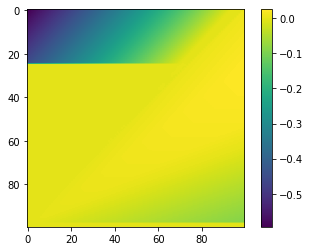

In [54]:
imgplot = plt.imshow(plot)
plt.colorbar()

In [ ]:
imgplot = plt.imshow(plot)
plt.colorbar()

In [147]:
precision = 10
met_max_uptake = 5
ox_max_uptake = 20
plot = np.zeros([precision, precision])
#conc_vec = np.linspace(0, max_uptake, precision)
methane_vec = np.linspace(0,met_max_uptake,precision)
oxygen_vec = np.linspace(0,ox_max_uptake,precision)
for count_met, met in enumerate(methane_vec):
    for count_ox, oxygen in enumerate(oxygen_vec):
        pheast.reactions.uptake_methane.bounds = met, met
        pheast.reactions.r1160.bounds = oxygen, oxygen
        pheast.objective = pheast.problem.Objective(pheast.reactions.r1339.flux_expression)
        pheast.reactions.r1339.bounds = pheast.optimize().objective_value, pheast.optimize().objective_value
        pheast.objective = pheast.problem.Objective(pheast.reactions.hemo_Biosynthesis.flux_expression)
        plot[count_met, count_ox] = pheast.optimize().objective_value

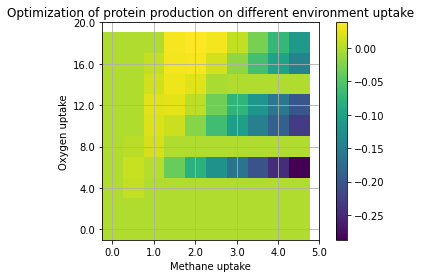

In [148]:
label_met = np.round(np.linspace(0, met_max_uptake, 6),1)
label_ox = np.round(np.linspace(0, ox_max_uptake, 6),1)
ticks = np.linspace(0, precision, 6)
imgplot = plt.imshow(plot)
plt.colorbar()
plt.title("Optimization of protein production on different environment uptake")
plt.xlabel("Methane uptake")
plt.ylabel("Oxygen uptake")
plt.gca().invert_yaxis()
plt.xticks(ticks, label_met)
plt.yticks(ticks, label_ox)
#plt.xticks(np.arange(precision),methane_vec)
plt.grid()

In [149]:
plot

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.00851179,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.01120015,  0.00266613, -0.0372538 , -0.07891396,
        -0.12057412, -0.16223428, -0.20389445, -0.24555461, -0.28721477],
       [ 0.        ,  0.00407415,  0.01702363,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.02119629,  0.01284274, -0.0204295 ,
        -0.06208966, -0.10374983, -0.14540999, -0.18707015, -0.22873031],
       [ 0.        ,  0.        ,  0.0224003 ,  0.02553537,  0.00533095,
        -0.03284744, -0.0745076 , -0.11616776

In [141]:
np.linspace(0, max_uptake, 6)

array([0. , 0.6, 1.2, 1.8, 2.4, 3. ])

In [135]:
ticks

array([ 0.,  2.,  4.,  6.,  8., 10.])

In [127]:
conc_vec

array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ])

In [ ]:
idx = np.round(np.linspace(0, len(arr) - 1, numElems)).astype(int)
idx = np.linspace(0, len(arr) - 1, numElems, dtype='int')

In [131]:
np.round(np.linspace(0, max_uptake, 6)).astype(int)

array([0, 1, 2, 3, 4, 5])